In [2]:
#Beating rate, 90% or 80% contraction amplitude, dp/dt, TTP, time to 90% relaxtion, tau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import simps
    

In [37]:
# Given values
frame_rate = 100  # Frames per second (e.g., 30 fps)
f_real = 1  # Real contraction frequency in Hz (e.g., 1 contraction every 2 seconds) ???????????

# Calculate the minimum time interval between contractions (in seconds)
T_min = 1 / f_real
#print(T_min)

# Calculate the minimum distance between peaks in frames
distance = int(frame_rate * T_min)

#file_name = 'SmartHeart_B2_'+str(f_real)+'Hz_008current001edit_analyzed_prediction_features.csv'
#file_name = 'SH_spont_A4_001current001.avi.csv'
file_name = "stress_1HZ_1_flood_fill.csv"
df =  pd.read_csv(file_name)


#contraction_stress, frame_time_point = df['contraction_stress (mPa*mm^2)'] , df['frame_time_point (s)'] # [mPa*mm^2] represent - load applied across a certain area, means [10^-9N or nN].
contraction_stress, frame_time_point = df['stress_kpa'] , df['frame'] # [mPa*mm^2] represent - load applied across a certain area, means [10^-9N or nN].


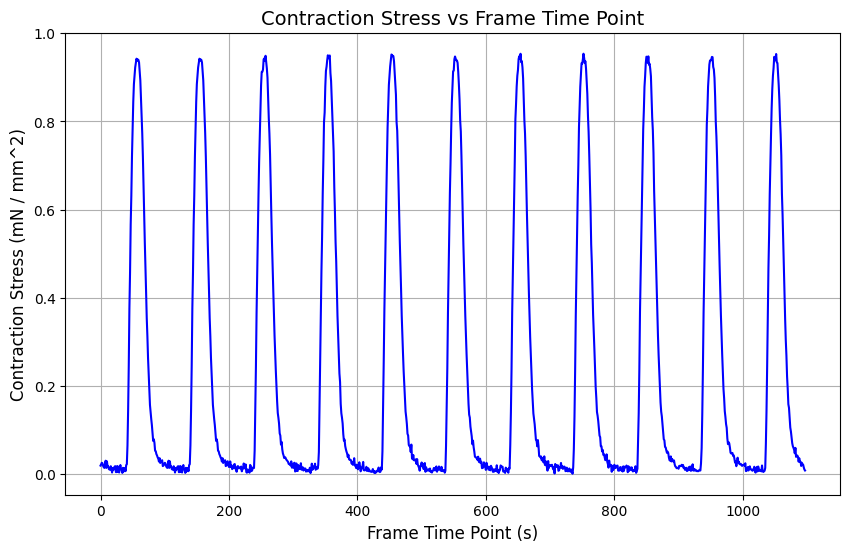

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point, contraction_stress, linestyle='-', color='b')
plt.title('Contraction Stress vs Frame Time Point', fontsize=14)
plt.xlabel('Frame Time Point (s)', fontsize=12)
plt.ylabel('Contraction Stress (mN / mm^2)', fontsize=12)
plt.grid(True)
plt.show()

peaks = [ 61 161 262 360 460 558 659 760 858 958]
troughs = [141 237 337 436 536 634 735 836 928]


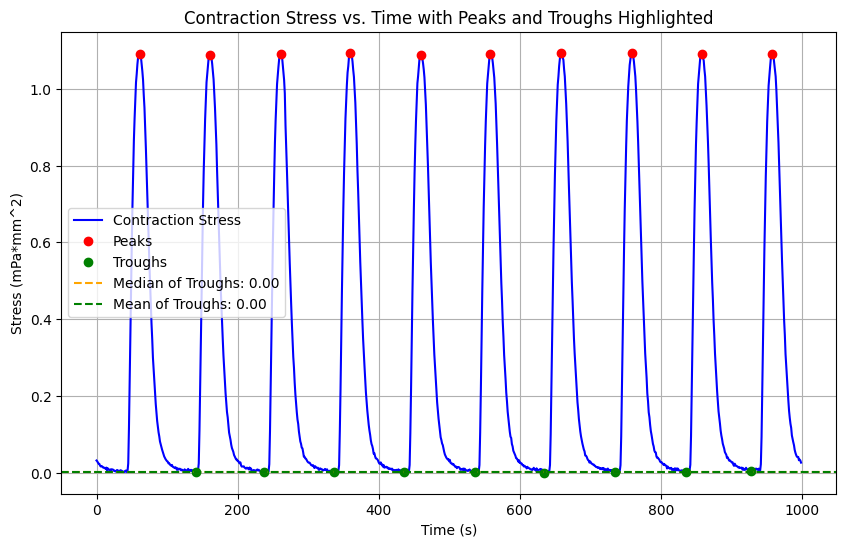

In [36]:
# Find the troughs (inverted peaks)
#It prevents detecting multiple closely spaced troughs that may not represent distinct events.
# Find the peaks
peaks, peak_properties = find_peaks(contraction_stress, prominence=0.1, distance = distance-10)
troughs, trough_properties = find_peaks(-contraction_stress, prominence=0.1, distance=distance-10)




print(f'peaks = {peaks}')
print(f'troughs = {troughs}')

# Calculate the mean of the troughs
trough_mean = np.mean(contraction_stress[troughs])

# Calculate the median of the troughs
trough_median = np.median(contraction_stress[troughs])

# Plot the stress data
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point, contraction_stress, label='Contraction Stress', color='blue')
plt.plot(frame_time_point[peaks], contraction_stress[peaks], 'ro', label='Peaks')  # Highlight the peaks
plt.plot(frame_time_point[troughs], contraction_stress[troughs], 'go', label='Troughs')  # Highlight the troughs\
# Add the median line
plt.axhline(trough_median, color='orange', linestyle='--', label=f'Median of Troughs: {trough_median:.2f}')


# Add the mean of the troughs as a horizontal line
plt.axhline(trough_mean, color='green', linestyle='--', label=f'Mean of Troughs: {trough_mean:.2f}')

# Labels, title, and legend
plt.xlabel('Time (s)')
plt.ylabel('Stress (mPa*mm^2)')
plt.title('Contraction Stress vs. Time with Peaks and Troughs Highlighted')
plt.legend()
plt.grid()
plt.show()

Trough 0: Start Index = 87, End Index = 147
Trough 1: Start Index = 186, End Index = 245
Trough 2: Start Index = 287, End Index = 344
Trough 3: Start Index = 385, End Index = 444
Trough 4: Start Index = 485, End Index = 543
Trough 5: Start Index = 583, End Index = 642
Trough 6: Start Index = 684, End Index = 743
Trough 7: Start Index = 785, End Index = 843
Trough 8: Start Index = 881, End Index = 938


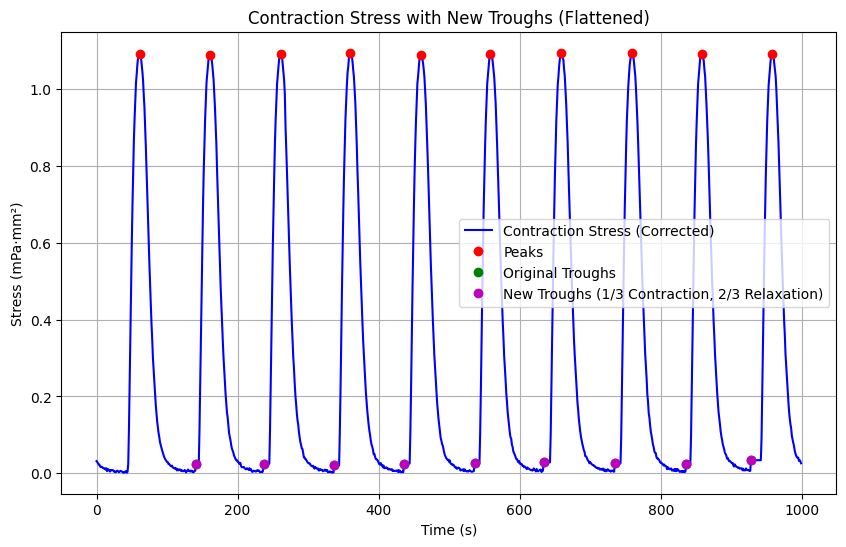

In [37]:
# Ensure contraction_stress is a NumPy array to allow safe modification
if isinstance(contraction_stress, pd.Series):
    contraction_stress = contraction_stress.to_numpy().copy()

new_trough_values = []
new_trough_times = []

for i, trough in enumerate(troughs):
    # Get the previous and next peaks
    prev_peaks = peaks[peaks < trough]
    next_peaks = peaks[peaks > trough]
    
    # Skip if no valid peak before or after
    if len(prev_peaks) == 0 or len(next_peaks) == 0:
        continue

    prev_peak = prev_peaks[-1]
    next_peak = next_peaks[0]

    # Calculate relaxation and contraction times
    relaxation_time = frame_time_point[trough] - frame_time_point[prev_peak]
    contraction_time = frame_time_point[next_peak] - frame_time_point[trough]
    time_per_frame = np.mean(np.diff(frame_time_point))

    # Define the averaging window
    start_index = int(trough - (2/3) * relaxation_time / time_per_frame)
    end_index = int(trough + (1/3) * contraction_time / time_per_frame)

    # Clamp indices to valid range
    start_index = max(0, start_index)
    end_index = min(len(contraction_stress), end_index)

    # Print the integration range (optional)
    print(f"Trough {i}: Start Index = {start_index}, End Index = {end_index}")

    # Average value around the trough
    avg_contraction_value = np.mean(contraction_stress[start_index:end_index])

    # Store results
    new_trough_values.append(avg_contraction_value)
    new_trough_times.append(frame_time_point[trough])

    # Modify the signal: flatten values that fall below the average trough
    for j in range(trough, next_peak):
        if contraction_stress[j] < avg_contraction_value:
            contraction_stress[j] = avg_contraction_value

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point, contraction_stress, label='Contraction Stress (Corrected)', color='blue')
plt.plot(frame_time_point[peaks], contraction_stress[peaks], 'ro', label='Peaks')
plt.plot(frame_time_point[troughs], contraction_stress[troughs], 'go', label='Original Troughs')
plt.plot(new_trough_times, new_trough_values, 'mo', label='New Troughs (1/3 Contraction, 2/3 Relaxation)')

plt.xlabel('Time (s)')
plt.ylabel('Stress (mPa·mm²)')
plt.title('Contraction Stress with New Troughs (Flattened)')
plt.legend()
plt.grid()
plt.show()


In [22]:
new_trough_values = []
new_trough_times = []
contraction_stress = contraction_stress.to_numpy().copy()
if isinstance(contraction_stress, pd.Series):
    contraction_stress = contraction_stress.to_numpy().copy()
    
for i, trough in enumerate(troughs):
    # --- Get neighboring peaks ---
    prev_peaks = peaks[peaks < trough]
    next_peaks = peaks[peaks > trough]

    # Safety check to avoid index errors
    if len(prev_peaks) == 0 or len(next_peaks) == 0:
        continue

    prev_peak = prev_peaks[-1]
    next_peak = next_peaks[0]

    # --- Calculate time intervals ---
    relaxation_time = frame_time_point[trough] - frame_time_point[prev_peak]
    contraction_time = frame_time_point[next_peak] - frame_time_point[trough]
    time_per_frame = np.mean(np.diff(frame_time_point))

    # --- Define the averaging window ---
    start_index = int(trough - (2/3) * relaxation_time / time_per_frame)
    end_index = int(trough + (1/3) * contraction_time / time_per_frame)

    start_index = max(0, start_index)
    end_index = min(len(contraction_stress), end_index)

    print(f"Trough {i}: Start Index = {start_index}, End Index = {end_index}")

    # --- Average contraction value ---
    avg_contraction_value = np.mean(contraction_stress[start_index:end_index])
    new_trough_values.append(avg_contraction_value)
    new_trough_times.append(frame_time_point[trough])

    # --- Smooth correction using interpolation ---
    beat_indices = np.arange(trough, next_peak + 1)
    start_val = avg_contraction_value
    end_val = contraction_stress[next_peak]
    interp_vals = np.linspace(start_val, end_val, len(beat_indices))

    for idx, interp_val in zip(beat_indices, interp_vals):
        if contraction_stress[idx] < interp_val:
            contraction_stress[idx] = interp_val

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point, contraction_stress, label='Contraction Stress (Corrected)', color='blue')
plt.plot(frame_time_point[peaks], contraction_stress[peaks], 'ro', label='Peaks')
plt.plot(frame_time_point[troughs], contraction_stress[troughs], 'go', label='Original Troughs')
plt.plot(new_trough_times, new_trough_values, 'mo', label='New Troughs (1/3 Contraction, 2/3 Relaxation)')

plt.xlabel('Time (s)')
plt.ylabel('Stress (mPa·mm²)')
plt.title('Contraction Stress with Smoothed New Troughs')
plt.legend()
plt.grid()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

peaks before cutting = [ 61 161 262 360 460 558 659 760 858 958]
peaks after cuuting = [161 262 360 460 558 659 760 858]


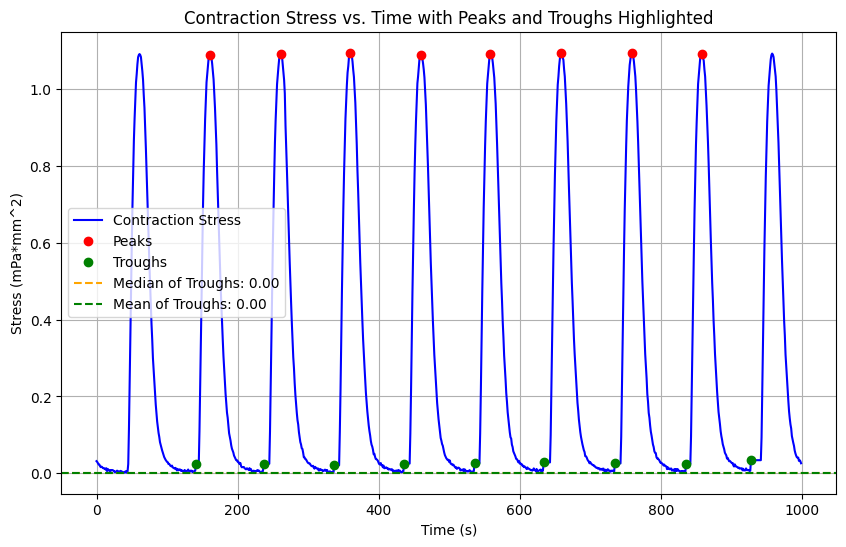

In [38]:
#cutting the peaks so the signal will start ans ens with a min point (relaxation)
valid_peaks = peaks
print(f'peaks before cutting = {peaks}')
if peaks[0] < troughs[0]:
    valid_peaks = valid_peaks[1:]
if peaks[-1] > troughs[-1]:
    valid_peaks = valid_peaks[:-1]

print(f'peaks after cuuting = {valid_peaks}')

# Plot the stress data
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point, contraction_stress, label='Contraction Stress', color='blue')
plt.plot(frame_time_point[valid_peaks], contraction_stress[valid_peaks], 'ro', label='Peaks')  # Highlight the peaks
plt.plot(frame_time_point[troughs], contraction_stress[troughs], 'go', label='Troughs')  # Highlight the troughs\
# Add the median line
plt.axhline(trough_median, color='orange', linestyle='--', label=f'Median of Troughs: {trough_median:.2f}')


# Add the mean of the troughs as a horizontal line
plt.axhline(trough_mean, color='green', linestyle='--', label=f'Mean of Troughs: {trough_mean:.2f}')

# Labels, title, and legend
plt.xlabel('Time (s)')
plt.ylabel('Stress (mPa*mm^2)')
plt.title('Contraction Stress vs. Time with Peaks and Troughs Highlighted')
plt.legend()
plt.grid()
plt.show()

In [39]:
# # Define the window size around each trough for calculating the mean
# window_size= 2
# right = 2  # Adjust this value as needed
# left = 4
# # Calculate the mean around each trough point
# area_trough = []
# i=1
# for trough in troughs:
#     start_idx = max(trough - left, 0)  # Ensure we don't go out of bounds
#     end_idx = min(trough + right, len(contraction_stress))  # Ensure we don't go out of bounds
#     print(f'{i}# trough = {trough}')
#     print(f'start = {start_idx}, end = {end_idx}')
#     print(f'contraction stress at the range of +- {window_size} frames: \n {contraction_stress[start_idx:end_idx]} \n')
#     i+=1
#     region_mean = np.mean(contraction_stress[start_idx:end_idx])
#     area_trough.append(region_mean)
    

# # Plot the stress data
# plt.figure(figsize=(10, 6))
# plt.plot(frame_time_point, contraction_stress, label='Contraction Stress', color='blue')  # Original data
# plt.plot(frame_time_point[peaks], contraction_stress[peaks], 'ro', label='Peaks')  # Highlight the peaks
# plt.plot(frame_time_point[troughs], contraction_stress[troughs], 'go', label='Original Troughs')  # Original troughs

# # Plot the new "troughs" for each cycle
# plt.plot(frame_time_point[troughs], area_trough, 'mo', label='New Troughs (Area Mean)')  # New trough values

# # Labels, title, and legend
# plt.xlabel('Time (s)')
# plt.ylabel('Stress (mPa*mm^2)')
# plt.title('Contraction Stress with New Troughs Based on Area Mean')
# plt.legend()
# plt.grid()
# plt.show()

# print(np.array(area_trough)- contraction_stress[troughs])



## Beating Rate

In [24]:
# Extract the time points of the peaks: get the time that the maxima point correlate
peak_times = frame_time_point.iloc[valid_peaks]
# Calculate the time intervals between consecutive peaks (in seconds)
time_intervals = np.diff(peak_times)
print(time_intervals)

# Calculate the average beating rate in beats per minute (BPM)
if len(time_intervals) > 0:  # Ensure there are enough peaks to calculate
    avg_interval = np.mean(time_intervals)  # Average time between beats
    beating_rate = 60 / avg_interval  # Convert to BPM
    print(f"Beating Rate: {beating_rate:.2f} BPM")
    print(f"calculated frequency: {1/avg_interval:.2f} Hz")
else:
    print("Not enough peaks to calculate beating rate.")

[101  98 100  98 101 101  98]
Beating Rate: 0.60 BPM
calculated frequency: 0.01 Hz


## 90% or 80% contraction amplitude

In [40]:
# Define the threshold percentage (90% of the amplitude)
threshold_percentage = 0.9  # 90% of the amplitude

# # Ensure that the number of peaks and troughs match, or handle cases where they don't
# peaks, _ = find_peaks(contraction_stress, prominence=0.1, distance=2)

# Align peaks and troughs based on proximity
min_length = min(len(valid_peaks), len(troughs))  # Ensure we're only using the shortest length
valid_peaks = valid_peaks[:min_length]
troughs = troughs[:min_length]

# Calculate peak-to-trough amplitude
amplitude_values = contraction_stress[valid_peaks] - contraction_stress[troughs]

# Find the threshold value (90% of the amplitude)
threshold_values = amplitude_values * threshold_percentage

# Calculate the mean of the threshold values
freq_contraction_amplitude = threshold_values.mean()

print(f"The {threshold_percentage*100}% contraction amplitude is: {freq_contraction_amplitude:.2f}")


The 90.0% contraction amplitude is: 0.96


In [ ]:
############# The 90.0% contraction amplitude from top ###############

# troughs, properties = find_peaks(-contraction_stress, prominence=0.1, distance=2) # Invert the signal to find minima

# # Define the threshold percentage (90% or 80%)
# threshold_percentage = 0.9  # top 90% of the amplitude

# # Calculate peak-to-trough amplitude
# amplitude_values = contraction_stress.iloc[peaks].values - contraction_stress.iloc[troughs].values

# # Find the threshold value (90% or 80% of the amplitude)
# threshold_values = amplitude_values * (1-threshold_percentage)
# top_freq_amplitude_values = amplitude_values - threshold_values 
# freq_contraction_amplitude = top_freq_amplitude_values.mean()

# print(f"The {threshold_percentage*100}% contraction amplitude is: {freq_contraction_amplitude:.2f} Hz")



## Rate of Change of Contraction Stress (dP/dt)

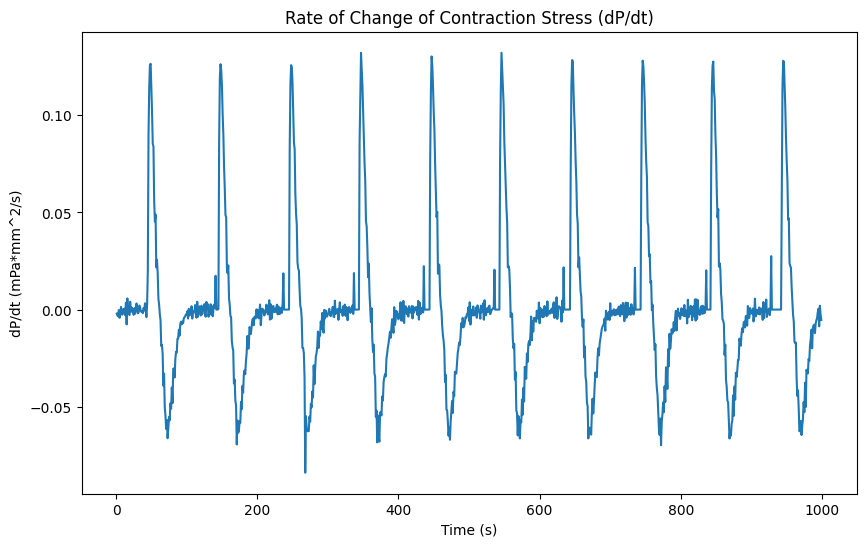

In [41]:
# Calculate the numerical derivative of contraction stress with respect to time (dp/dt)
# We will use np.diff to get the difference between consecutive values in contraction_stress
# And then divide by the time difference (which is constant if the data is sampled at equal time intervals)

# Calculate the time differences between consecutive time points
time_diff = np.diff(frame_time_point)

# Calculate the difference in stress values between consecutive measurements
stress_diff = np.diff(contraction_stress)

# Calculate dP/dt (rate of change of stress with respect to time)
dp_dt = stress_diff / time_diff

# Plot dP/dt (rate of change of contraction stress)
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point[1:], dp_dt)  # Starting from the second time point since np.diff reduces length by 1
plt.xlabel('Time (s)')
plt.ylabel('dP/dt (mPa*mm^2/s)')
plt.title('Rate of Change of Contraction Stress (dP/dt)')
plt.show()


In [42]:
# #bar graph
# '''The first bar corresponds to the rate of change between Frame 1 and Frame 2.
# The second bar corresponds to the rate of change between Frame 2 and Frame 3.
# And so on.
# '''
# # Plot a bar graph of dP/dt

# plt.figure(figsize=(15, 8))
# plt.bar(range(1, len(dp_dt) + 1), dp_dt, width=0.8) 
# plt.xlabel('Frame Index')
# plt.ylabel('∆P/∆t (mPa*mm^2/s)')
# plt.title('Rate of Change of Contraction Stress (∆P/∆t) for Each Frame')
# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()


## Time to peak
The TTP is the time interval between the trough (the minimum point) and the peak (the maximum point) in each cycle.

Steps to Calculate TTP:

In [43]:
#we have to start from a trough ans calac to the next peak.
TTP_values = []
for peak, trough in zip(valid_peaks, troughs[:-1]):
    # Time at peak and trough
    peak_time = frame_time_point.iloc[peak]
    trough_time = frame_time_point.iloc[trough]
    
    # Calculate TTP (Time to Peak)
    TTP = peak_time - trough_time
    TTP_values.append(TTP)

print(f'peaks = {valid_peaks}')
print(f'troughs = {troughs[:-1]}')
print(len(valid_peaks),len(troughs[:-1]))

print(TTP_values)

# Calculate the mean TTP (average time to peak)
mean_TTP = np.mean(TTP_values)

# Print the results
print(f"The average Time to Peak (TTP) is: {mean_TTP:.3f} seconds")

peaks = [161 262 360 460 558 659 760 858]
troughs = [141 237 337 436 536 634 735]
8 7
[20, 25, 23, 24, 22, 25, 25]
The average Time to Peak (TTP) is: 23.429 seconds


## time to 90% relaxtion

In [44]:
TTR_values = []
threshold_precentage = 0.9
for peak in peaks:
    # Get the peak value
    peak_value = contraction_stress.iloc[peak]
    
    # Define the 90% relaxation value
    relaxation_value = peak_value * (1- threshold_precentage)
    
    # Find the first point after the peak where contraction stress is less than or equal to 90% of the peak value
    relaxation_time = None
    for i in range(peak + 1, len(contraction_stress)):
        if contraction_stress.iloc[i] <= relaxation_value:
            relaxation_time = frame_time_point.iloc[i]
            break
    
    if relaxation_time is not None:
        # Calculate the time to 90% relaxation (TTR)
        peak_time = frame_time_point.iloc[peak]
        TTR = relaxation_time - peak_time
        TTR_values.append(TTR)

# Calculate the mean TTR (average time to 90% relaxation)
mean_TTR = np.mean(TTR_values)

# Print the results
print(f"The average Time to 90% Relaxation (TTR) is: {mean_TTR:.3f} seconds")

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

## Time constant Tau (τ)
$P(t) = P_{\text{baseline}} + (P_{\text{max}} - P_{\text{baseline}}) \cdot e^{-\frac{t}{\tau}}$

we need to solve for $\tau$ in each cycle by fitting the data from the baseline (trough) to the maximum (peak). The following approach will use curve fitting to determine $\tau$ for each cycle:

In [ ]:
# from scipy.optimize import curve_fit

# # Define the exponential function
# def exp_func(t, tau, P_baseline, P_max):
#     return P_baseline + (P_max - P_baseline) * np.exp(-t / tau)

# tau_values = []

# # Loop through each peak and trough pair
# for peak, trough in zip(peaks, troughs):
#     # Extract data for the current contraction phase
#     contraction_time = frame_time_point.iloc[trough:peak + 1].values  # Time between trough and peak
#     contraction_stress_phase = contraction_stress.iloc[trough:peak + 1].values  # Stress between trough and peak

#     # Initial guess for [tau, P_baseline, P_max]
#     initial_guess = [1.0, contraction_stress_phase[0], contraction_stress_phase[-1]]

#     try:
#         # Fit the exponential function to the contraction data
#         popt, _ = curve_fit(exp_func, contraction_time, contraction_stress_phase, p0=initial_guess)

#         # Extract the time constant (tau) from the fit
#         tau_values.append(popt[0])
#     except RuntimeError:
#         print(f"Curve fitting failed for trough at {frame_time_point.iloc[trough]} to peak at {frame_time_point.iloc[peak]}")

# # Calculate the mean tau if there are valid values
# if tau_values:
#     mean_tau = np.mean(tau_values)
#     print(f"The average time constant (tau) from baseline to peak contraction is: {mean_tau:.3f} seconds")
# else:
#     print("No valid tau values could be calculated.")

# # Optionally, plot the fitted curves for each cycle
# plt.figure(figsize=(10, 6))
# plt.plot(frame_time_point, contraction_stress, label='Contraction Stress', color='blue')  # Original data
# plt.plot(frame_time_point[peaks], contraction_stress[peaks], 'ro', label='Peaks')  # Peaks
# plt.plot(frame_time_point[troughs], contraction_stress[troughs], 'go', label='Troughs')  # Troughs

# # Add fitted curves for visualization
# for peak, trough in zip(peaks, troughs):
#     contraction_time = frame_time_point.iloc[trough:peak + 1].values  # Time between trough and peak
#     if len(tau_values) > 0:  # Only plot if fitting succeeded
#         fitted_curve = exp_func(contraction_time, *popt)  # Use fitted parameters
#         plt.plot(contraction_time, fitted_curve, label=f'Fitted Curve (Cycle {trough}-{peak})')

# # Labels, title, and legend
# plt.xlabel('Time (s)')
# plt.ylabel('Stress (mPa*mm^2)')
# plt.title('Contraction Stress with Exponential Fits')
# plt.legend()
# plt.grid()
# plt.show()


In [ ]:
# # Loop through each peak to calculate time to reach 67% of peak value from the trough
# tau_values_from_relaxation_to_peak = []

# for peak, trough in zip(peaks, troughs):
#     peak_value = contraction_stress.iloc[peak]  # Peak contraction stress
#     trough_value = contraction_stress.iloc[trough]  # Trough value (relaxation phase)
    
#     peak_time = frame_time_point.iloc[peak]  # Time corresponding to the peak
#     trough_time = frame_time_point.iloc[trough]  # Time corresponding to the trough

#     # Calculate 67% of the peak contraction stress
#     relaxation_threshold = 0.63 * peak_value

#     # Extract contraction phase data (data after the trough and before the peak)
#     contraction_time = frame_time_point.iloc[trough:peak + 1]  # Time between trough and peak
#     contraction_stress_phase = contraction_stress.iloc[trough:peak + 1]  # Contraction stress between trough and peak

#     # Find the time when contraction stress first reaches 63% of the peak value
#     crossing_indices = np.where(contraction_stress_phase >= relaxation_threshold)[0]

#     if crossing_indices.size > 0:  # Check if the threshold is crossed
#         crossing_index = crossing_indices[0]  # Find first crossing
#         # Calculate time to reach 67% of the peak value from the trough
#         time_to_63_from_contraion = contraction_time.iloc[crossing_index] - trough_time
#         tau_values_from_relaxation_to_peak.append(time_to_67_from_relaxation)  # Store the tau value for this cycle
#     else:
#         print(f"No crossing found for peak at time {peak_time} (Trough time: {trough_time})")

# # Check if there are any valid tau values calculated
# if tau_values_from_relaxation_to_peak:
#     mean_tau_from_relaxation_to_peak = np.mean(tau_values_from_relaxation_to_peak)
#     print(f"The average time constant (tau) from relaxation to 63% of peak contraction is: {mean_tau_from_relaxation_to_peak:.3f} seconds")
# else:
#     print("No valid tau values could be calculated.")

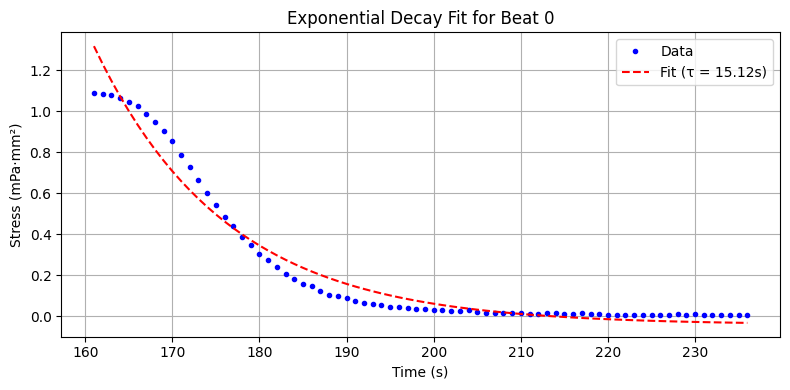

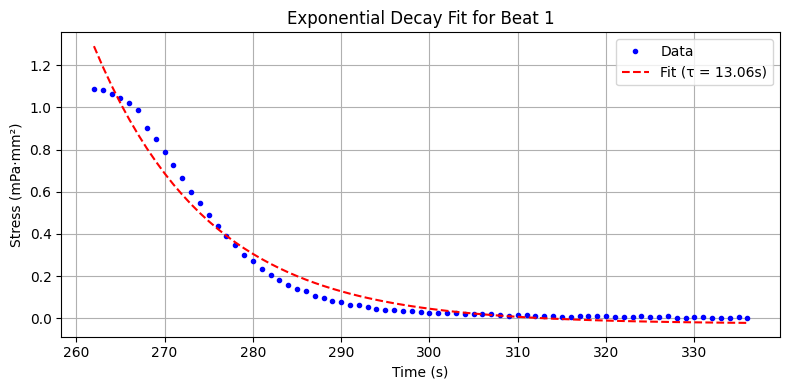

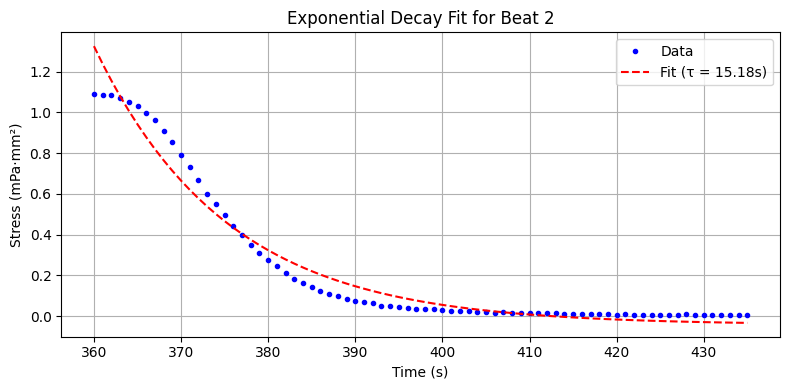

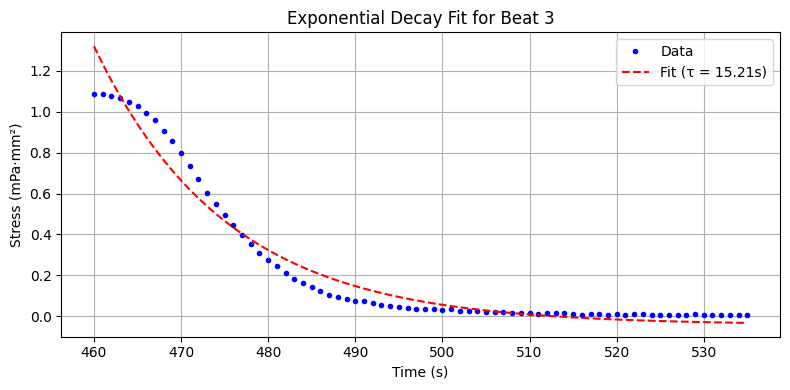

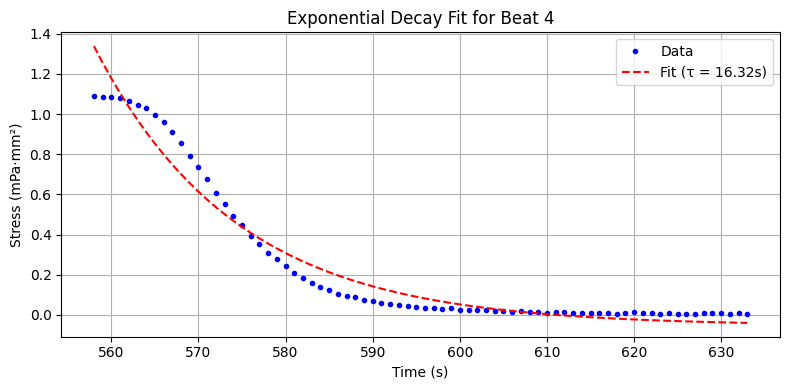

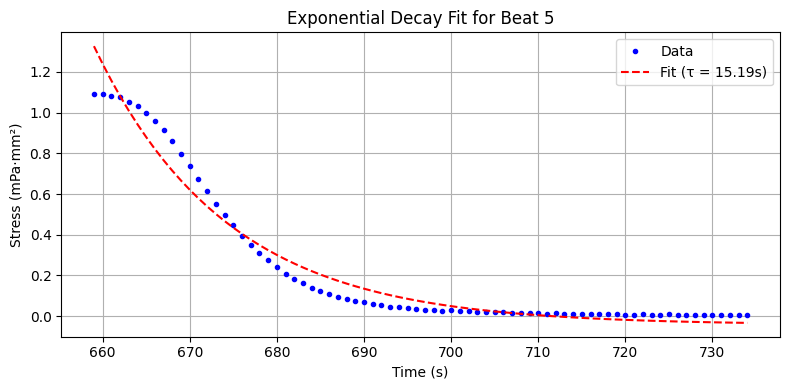

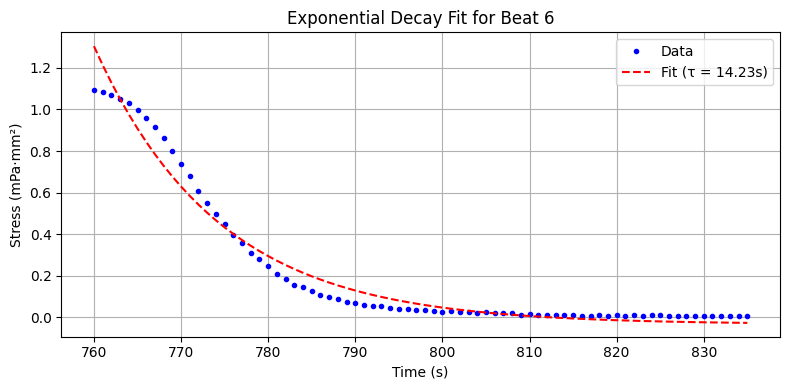

In [47]:
from scipy.optimize import curve_fit

def exp_decay(t, P0, Pasym, tau):
    return (P0 - Pasym) * np.exp(-t / tau) + Pasym

taus = []  # to store τ for each beat

# Make sure everything is NumPy arrays
if isinstance(frame_time_point, pd.Series):
    frame_time_point = frame_time_point.to_numpy()
if isinstance(contraction_stress, pd.Series):
    contraction_stress = contraction_stress.to_numpy()

# Loop through peaks to next trough
for i in range(len(valid_peaks)):
    peak_idx = valid_peaks[i]
    # Find the next trough after this peak
    following_troughs = troughs[troughs > peak_idx]
    if len(following_troughs) == 0:
        continue
    trough_idx = following_troughs[0]

    # Extract decay segment
    t_segment = frame_time_point[peak_idx:trough_idx]
    s_segment = contraction_stress[peak_idx:trough_idx]

    # Check if segment is valid
    if len(t_segment) < 3:
        print(f"Skipping beat {i}: segment too short.")
        continue

    t_decay = t_segment - t_segment[0] #This shifts the time vector so that it starts at 0
    p_decay = s_segment

    # Guess parameters
    P0_guess = p_decay[0]
    Pasym_guess = p_decay[-1]
    tau_guess = (t_decay[-1] - t_decay[0]) / 2

    try:
        popt, _ = curve_fit(exp_decay, t_decay, p_decay,
                            p0=[P0_guess, Pasym_guess, tau_guess],
                            maxfev=10000)
        P0_fit, Pasym_fit, tau_fit = popt #contains the best-fit values for [P0, Pasym, tau].
        taus.append(tau_fit)

        # Plot result
        fit_curve = exp_decay(t_decay, *popt)
        plt.figure(figsize=(8, 4))
        plt.plot(t_segment, p_decay, 'b.', label='Data')
        plt.plot(t_segment, fit_curve, 'r--', label=f'Fit (τ = {tau_fit:.2f}s)')
        plt.title(f'Exponential Decay Fit for Beat {i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Stress (mPa·mm²)')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    except RuntimeError:
        print(f"Fit failed for beat {i}")

In [31]:
mean_tau = np.mean(taus)
print(f"Average Tau: {mean_tau:.4f} seconds")

Average Tau: 14.9020 seconds
